In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

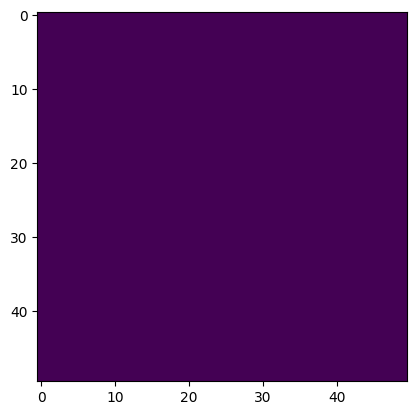

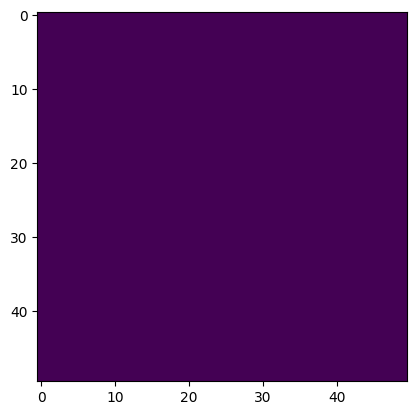

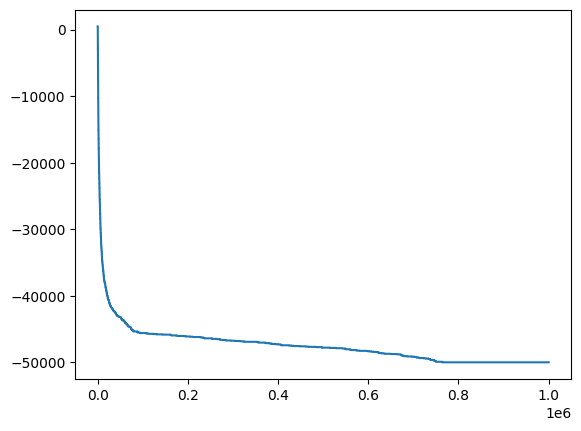

In [ ]:
def energy(a,j):
    h = -j * (a * (np.roll(a,1,axis=0) + np.roll(a,1, axis = 1)))
    return np.sum(h)


def randominitial(n):
    b = np.random.choice(2,(n,n))
    b[b==0] = -1
    return b

def convergence(steps:int, n,j,a_in):

    numsteps = 1000
    skipsteps = steps//numsteps

    a = a_in.copy()

    energies = np.empty(steps)

    oldenergy = energy(a,j)

    data = []

    for i in range(steps):
        energies[i] = oldenergy

        if i % skipsteps == 0:
            data.append(a)
        
        
        x = np.random.randint(0,n)
        y = np.random.randint(0,n)

        b = a.copy()
        b[x,y] *= -1

        stepenergy = oldenergy + j*(a[x,y]-b[x,y])*(a[x,(y+1)%n] + a[(x+1)%n,y] + a[x,y-1] + a[x-1,y])

        '''if i % 100000 == 0:
            plt.imshow(a)
            plt.title(f"{i}th step")
            plt.show()
        '''
        
        if stepenergy <= oldenergy:
            a = b.copy()
            oldenergy = stepenergy
        else:
            continue
        
    fig, ax = plt.subplots()
    im = ax.imshow(data[0])

    def update(frame):
        im.set_array(data[frame])
        return [im]

    ani = anim.FuncAnimation(fig, update, frames=steps//skipsteps, interval=10, blit=True)

    ani.save("animation.mp4", fps=60)

    plt.show()

    return np.arange(steps), energies, a


n = 50
a_in = randominitial(n)
step, u, a = convergence(int(1e6), n, 10, a_in)

#plt.imshow(a)
#plt.show()

plt.plot(step, u)
plt.show()
